# Notebook for the development of the model to power the face detection

### Imports

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import cv2
import torch
from torchvision.datasets import WIDERFace

### Data

In [5]:
WIDERFace(root="", download=True)

Downloading...
From (original): https://drive.google.com/uc?id=15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M
From (redirected): https://drive.usercontent.google.com/download?id=15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M&confirm=t&uuid=5595fd15-1c69-4409-b1f8-7518b2678048
To: /content/widerface/WIDER_train.zip
100%|██████████| 1.47G/1.47G [00:29<00:00, 50.3MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q
From (redirected): https://drive.usercontent.google.com/download?id=1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q&confirm=t&uuid=31600757-0cbc-4a96-9f2b-5c4ef53ca0ff
To: /content/widerface/WIDER_val.zip
100%|██████████| 363M/363M [00:07<00:00, 47.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1HIfDbVEWKmsYKJZm4lchTBDLW5N7dY5T
From (redirected): https://drive.usercontent.google.com/download?id=1HIfDbVEWKmsYKJZm4lchTBDLW5N7dY5T&confirm=t&uuid=12bd54e7-5037-43c9-b094-28acecf5b672
To: /content/widerface/WIDER_test.zip
100%|██████████| 1.84G/1.84G 

100%|██████████| 3591642/3591642 [00:00<00:00, 38066119.53it/s]

Extracting widerface/wider_face_split.zip to widerface


Dataset WIDERFace
    Number of datapoints: 12880
    Root location: widerface
    Split: train

[]

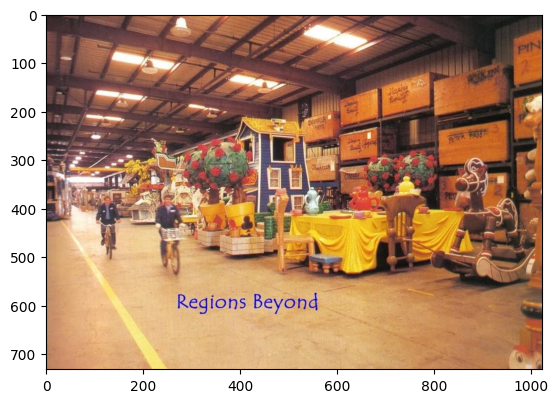

In [12]:
plt.imshow(mpimg.imread("/content/widerface/WIDER_train/images/0--Parade/0_Parade_Parade_0_1014.jpg"))
plt.plot()